# Multi-Country SIR Model
## by Colin Snow and Meg Ku

### Question:
How does a plague/disease spread from one country to another?

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Model:
We plan to make a model that simulates the cycle of infection between two large populations. 

First we create a model with arbitrary parameters to ensure its functionality. 

Here we set the initial state and system variables.
We define "movementRate" as the fraction of the population moving per day.  The values here are arbitrary; we are just trying to see if it can be implemented in our model below.

In [38]:
#Set initial state variables
state = State(s1=99,s2=99,i1=5,i2=0,r1=0,r2=0)
init  = State(s1=99,s2=99,i1=5,i2=0,r1=0,r2=0)

#globally defining system variables
'''
t0 = 1,
dt = 0.01
t_end = 100
'''
infectionRate1 = 0.01
recoveryRate1 = 0.05
infectionRate2 = 0.01
recoveryRate2 = 0.05
movementRate = 1 
immunizationFactor1=0  #fraction of people to be immunized before model starts in group 1 and 2
immunizationFactor2=0  #set to 0 to disable immunization

#Creating our system
system = System(init=init, 
                t0=1,
                t_end=80,
                infectionRate1=infectionRate1,
                recoveryRate1=recoveryRate1, 
                infectionRate2=infectionRate2,
                recoveryRate2=recoveryRate2,
                movementRate=movementRate, 
                dt=.01)

,values
init,s1 99 s2 99 i1 5 i2 0 r1 0 r...
t0,1
t_end,80
infectionRate1,0.01
recoveryRate1,0.05
infectionRate2,0.01
recoveryRate2,0.05
movementRate,1
dt,0.01


Here we used the ODE solver to update our model.

In [39]:
def slope_func(state, t, system):
    '''
    finds dx/dt for each stock and returns them
    inputs:
        state current state variable at time t
        t = current time
        system = model's system variable
    output:
        updated rates
        
    '''
    
    unpack(system)
    s1, s2, i1, i2, r1, r2 = state
    if (flip(.5)and i2>=0):
        infectedPeopleMoved = .0006
    elif(i1>0):
        infectedPeopleMoved = -.0006
   
    ds1dt = -(infectionRate1*s1*i1)
    ds2dt = -(infectionRate2*s2*i2)
    di1dt = (infectionRate1*s1*i1) - i1*recoveryRate1 + infectedPeopleMoved
    di2dt = (infectionRate2*s2*i2) - i2*recoveryRate2 - infectedPeopleMoved
    dr1dt = i1*recoveryRate1
    dr2dt = i2*recoveryRate2
    return ds1dt, ds2dt, di1dt, di2dt, dr1dt, dr2dt

In [40]:
#Run ODE solver to test functions
results, details = run_ode_solver(system, slope_func,max_step=.1)

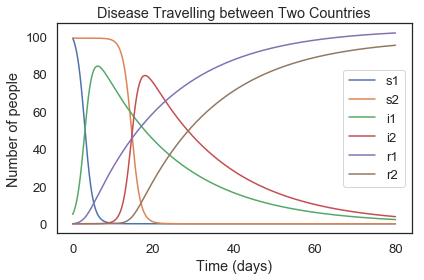

In [43]:
#Plot the results
results.plot()
decorate(title="Disease Travelling between Two Countries",
        xlabel="Time (days)",
        ylabel="Number of people")

As shown above, the model produces two SIR outputs; there is a significant offset in time for the disease outbreak in Country 2.

### Trying to model to real data
http://www.math.unm.edu/~sulsky/mathcamp/ApplyData.pdf

In order to get a better idea of infection rates for real data, lets consider three different real world diseases and how their infection statistics relate. We collected data for the following diseases: influenza, the bubonic plague, and ebola.

The values of the infection rates were experimentally calculated by running the simulation multiple times to find the best fit.

In [53]:
## Data for Influenza from 1930s in Arkansas
from pandas import read_html
table=pd.read_csv('data/influenzaData.csv')

state = State(s1=1500,s2=99,i1=1,i2=0,r1=0,r2=0)
init  = State(s1=1500,s2=99,i1=1,i2=0,r1=0,r2=0)

infectionRate1 = 0.0015

recoveryRate1 = 0.2
infectionRate2 = 0.01
recoveryRate2 = 0.05
movementRate = 0

#Creating our system
system = System(init=init, 
                t0=15,
                t_end=50,
                infectionRate1=infectionRate1,
                recoveryRate1=recoveryRate1, 
                infectionRate2=infectionRate2,
                recoveryRate2=recoveryRate2,
                movementRate=movementRate, 
                dt=.01)

def slope_func2(state, t, system):
    '''
    finds dx/dt for each stock and returns them
    inputs:
        state current state variable at time t
        t = current time
        system = model's system variable
    output:
        updated rates
        
    '''
    unpack(system)
    s1, s2, i1, i2, r1, r2 = state
    ## infectedPeopleMoved= movementRate*np.random.randn()
    infectedPeopleMoved = 0
    if (flip(.3) and i2>=0):
        infectedPeopleMoved = .000001
    elif(i1>0):
        infectedPeopleMoved = -.000001
   
    ds1dt = -(infectionRate1*s1*i1)
    ds2dt = -(infectionRate2*s2*i2)
    di1dt = (infectionRate1*s1*i1) - i1*recoveryRate1 + infectedPeopleMoved
    di2dt = (infectionRate2*s2*i2) - i2*recoveryRate2 - infectedPeopleMoved
    dr1dt = i1*recoveryRate1
    dr2dt = i2*recoveryRate2
    return ds1dt, ds2dt, di1dt, di2dt, dr1dt, dr2dt

results2,details=run_ode_solver(system, slope_func2,  max_step=.1)

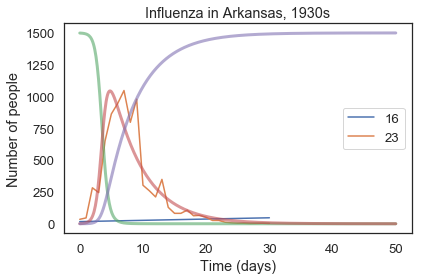

In [54]:
## Plot shows infection rate of about .000214 per day
## we ignored the other values in the table.

table.plot()
plot(results2.index,results2.s1)
plot(results2.index,results2.i1)
plot(results2.index,results2.r1)
decorate(title="Influenza in Arkansas, 1930s",
        xlabel="Time (days)",
        ylabel="Number of people")

In [62]:
##Eyam village bubonic plague, 1665-66

newSusceptible=(235,201,153.5,121,108,97,81,83)
newInfected=(14.5,22,29,20,8,8,2,0)

time=(0,5,10,15,20,25,30,35)

state = State(s1=254,s2=99,i1=7,i2=0,r1=0,r2=0)
init  = State(s1=254,s2=99,i1=7,i2=0,r1=0,r2=0)

infectionRate1 = .0032

recoveryRate1 = 2.82/5
infectionRate2 = 0.01
recoveryRate2 = 0.05
movementRate = 0
system = System(init=init, 
                t0=1,
                t_end=40,
                infectionRate1=infectionRate1,
                recoveryRate1=recoveryRate1, 
                infectionRate2=infectionRate2,
                recoveryRate2=recoveryRate2,
                movementRate=movementRate, 
                dt=.01)
results2,details=run_ode_solver(system, slope_func2, max_step=.1)

This model gave us data for both infected and susceptible people, so we fit the infection rate ntil both were modelled accurately.

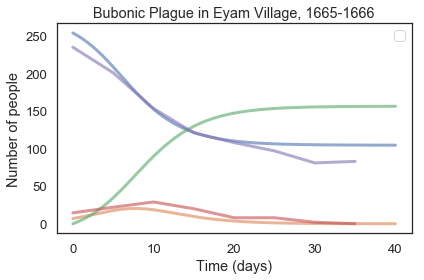

In [63]:
## plot shows normal infection rate of about .00064 per day
plot(results2.index,results2.s1)
plot(results2.index,results2.i1)
plot(results2.index,results2.r1)
plot(time,newInfected)
plot(time,newSusceptible)
decorate(title="Bubonic Plague in Eyam Village, 1665-1666",
        xlabel="Time (days)",
        ylabel="Number of people")

In this model, we again had only the fraction infected, but with the probable recovery rate and this data we were able to model all three populations.

In [64]:
##English Boarding School Influenza, 1938

sick=( 3,8,28,75,221,291,255,235,190,125,70 ,28,12,5)

time=(0,1,2,3,4,5,6,7,8,9,10,11,12,13)

state = State(s1=762,s2=99,i1=1,i2=0,r1=0,r2=0)
init  = State(s1=762,s2=99,i1=1,i2=0,r1=0,r2=0)

infectionRate1 = .0026

recoveryRate1 = .5
infectionRate2 = 0.01
recoveryRate2 = 0.05
movementRate = 0
system = System(init=init, 
                t0=1,
                t_end=40,
                infectionRate1=infectionRate1,
                recoveryRate1=recoveryRate1, 
                infectionRate2=infectionRate2,
                recoveryRate2=recoveryRate2,
                movementRate=movementRate, 
                dt=.01)
results2,details=run_ode_solver(system, slope_func2, max_step=.1)

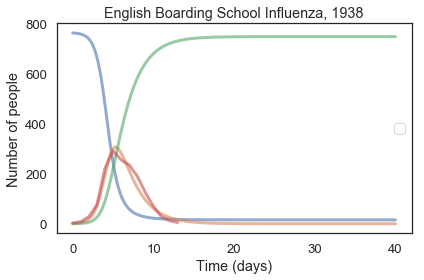

In [65]:
## plot shows normal infection rate of about .0026 per day
plot(results2.index,results2.s1)
plot(results2.index,results2.i1)
plot(results2.index,results2.r1)
plot(time,sick)
decorate(title="English Boarding School Influenza, 1938",
        xlabel="Time (days)",
        ylabel="Number of people")

### Conclusions from Data:
Infection rate can be up to .0026 per day for influenza in closely packed areas (schools) but is more normally about .000214 in open areas if the succeptible population is assumed to be slightly larger than the total infected number. Bubonic plague had a .00064 infection rate in an old time village, which may be more accurate in developing countries.

In [68]:
##Ebola outbreak in liberia in 2014

state = State(s1=4292419,s2=99,i1=846,i2=0,r1=735,r2=0)
init= State(s1=4292419,s2=99,i1=846,i2=0,r1=735,r2=0)

infectionRate1 = 1.63e-7

recoveryRate1 = .1
infectionRate2 = 0.01
recoveryRate2 = 0.05
movementRate = 0
system = System(init=init, 
                t0=1,
                t_end=60,
                infectionRate1=infectionRate1,
                recoveryRate1=recoveryRate1, 
                infectionRate2=infectionRate2,
                recoveryRate2=recoveryRate2,
                movementRate=movementRate, 
                dt=.01)
results2,details=run_ode_solver(system, slope_func2, max_step=.1)

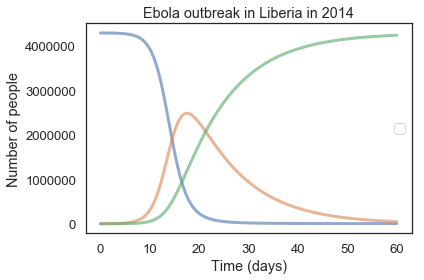

In [69]:
## plot shows normal infection rate of about 1.67e-7
plot(results2.index,results2.s1)
plot(results2.index,results2.i1)
plot(results2.index,results2.r1)
decorate(title="Ebola outbreak in Liberia in 2014",
        xlabel="Time (days)",
        ylabel="Number of people")

### Infection Analysis:
By taking these infection rates in their respective populations, we were able to graph infection rate versus population, creating a rational equation that can output an infection rate for any population size.

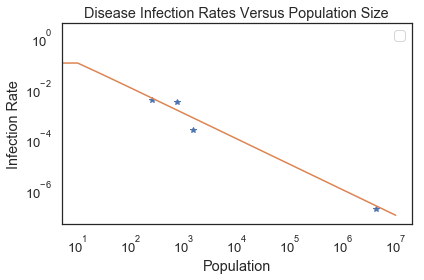

In [74]:
## We find the infection rate to be proportional to a rational function with an a of about .934 which is supported by
## the paper on aids

infectionRates=(.000214,.0032,.0026,1.63e-7)
populations=(1500,254,762,4292419)
import matplotlib.pyplot as plt
plt.loglog(populations,infectionRates,'*')

## best fit rational equation is .934/(population+.6787)
populationArray=linrange(0,10e6,10)
plt.loglog(populationArray,.934/(populationArray+.6787))
decorate(title="Disease Infection Rates Versus Population Size",
        xlabel="Population",
        ylabel="Infection Rate")

Here we create a function that creates this infection rate from our function.

In [15]:
def createInfectionRate (population):
    return 0.002147*exp(-2.21e-06*(population))
def createInfectionRateRational(population):
    return .934/(population+.6787)

### Results:
Now we apply this information to a model of France and Spain. We crerate a disease in France, and watch as people travelling between the countries spread it. The infection rates are determined by our function, and the travel rates are determined by tourism data that we collected. THe net travel rate is about zero as we are focusing on vacationers, but this movement is enough to quickly spread the disease across borders.

In [91]:
## Using France and Spain
##country1=France
##country2=Spain
## as of 2014

population1=66320000
population2=46480000

state = State(s1=population1,s2=population2,i1=100,i2=0,r1=0,r2=0)
init  = State(s1=population1,s2=population2,i1=100,i2=0,r1=0,r2=0)

infectionRate1 = createInfectionRateRational(population1)
recoveryRate1 = 0.1
infectionRate2 = createInfectionRateRational(population2)
recoveryRate2 = 0.1
movementRate = 1

#Creating our system
system = System(init=init, 
                t0=15,
                t_end=100,
                infectionRate1=infectionRate1,
                recoveryRate1=recoveryRate1, 
                infectionRate2=infectionRate2,
                recoveryRate2=recoveryRate2,
                movementRate=movementRate, 
                dt=.01)

movedto2=0
movedto1=0
def slope_func3(state, t, system):
    '''
    finds dx/dt for each stock and returns them
    inputs:
        state current state variable at time t
        t = current time
        system = model's system variable
    output:
        updated rates
    '''
    unpack(system)
    s1, s2, i1, i2, r1, r2 = state
    ## infectedPeopleMoved= movementRate*np.random.randn()
    infectedPeopleMoved = 0
    global movedto2
    global movedto1
    if (flip(.5)and i2>=0):
        infectedPeopleMoved = (.000360 + .000380)*2
        movedto2+=.000001
    elif(i1>0):
        infectedPeopleMoved = -(.000360 + .000380)*2
        movedto1+=.000001
   
    ds1dt = -(infectionRate1*s1*i1)
    ds2dt = -(infectionRate2*s2*i2)
    di1dt = (infectionRate1*s1*i1) - i1*recoveryRate1 + infectedPeopleMoved*(i1+i2)
    di2dt = (infectionRate2*s2*i2) - i2*recoveryRate2 - infectedPeopleMoved*(i1+i2)
    dr1dt = i1*recoveryRate1
    dr2dt = i2*recoveryRate2
    return ds1dt, ds2dt, di1dt, di2dt, dr1dt, dr2dt

results3,details=run_ode_solver(system, slope_func3, max_step=.1)

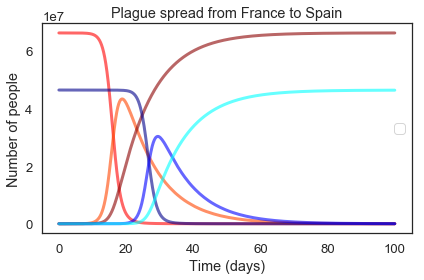

In [92]:
plot(results3.index,results3.s1,'red')
plot(results3.index,results3.i1,'orangered')
plot(results3.index,results3.r1,'darkred')
plot(results3.index,results3.s2,'darkblue')
plot(results3.index,results3.i2,'blue')
plot(results3.index,results3.r2,'cyan')
decorate(title="Plague spread from France to Spain",
        xlabel="Time (days)",
        ylabel="Number of people")

Red lines represent S,I,and R for France, and Blue lines represent S,I,and R for Spain. There is a noticeable delay in Spain's infection in this model, showing the time the disease takes to travel.

### Interpretation:
With the given parameters, there is about a 10 day offset between the peaks of infection in the two countries. Though, this model does assume several factors in order to simplify it. We assume that the disease is isolated within the countries, that everyone that travels to another country returns, that there is no immunization, and that the populations remain constant.

Overall, our model projects that there is a measurable delay between peak infections and that this delay is directly caused by their travel rates.